In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.display import display, Markdown
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/playground-series-s5e4/sample_submission.csv
../kaggle/input/playground-series-s5e4/test.csv
../kaggle/input/playground-series-s5e4/train.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt


In [28]:
def merge_rare_categories(df, feature, threshold):
    value_counts = df[feature].value_counts()

    to_remove = value_counts[value_counts < threshold].index
    print(to_remove)

    # Replace the data cell with NaN
    df[feature] = df[feature].apply(lambda x: x if x not in to_remove else None)

    print(df.head(25))
    return df

In [29]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [30]:
def plot_heatmap(df, feature, target):
    # Absolute values calculation (number of cases per feature and target)
    degree_dep_table = pd.crosstab(df[feature], df[target])

    # Check if target has only two categories (e.g., binary classification)
    if len(degree_dep_table.columns) == 2:
        # Sort rows by the number of cases where target = 1 (depression cases)
        degree_dep_table = degree_dep_table.sort_values(by=1, ascending=False)

    # Relative values calculation (row-wise normalization to get percentage values)
    degree_dep_table_rel = degree_dep_table.div(degree_dep_table.sum(axis=1), axis=0) * 100

    # Ensure that the sorting is applied to both tables
    degree_dep_table_rel = degree_dep_table_rel.loc[degree_dep_table.index]

    # Combined display: Absolute values + percentage values in one cell
    combined_table = degree_dep_table.astype(str) + " (" + degree_dep_table_rel.round(2).astype(str) + "%)"

    # Plot heatmap
    plt.figure(figsize=(35, 12))
    sns.heatmap(degree_dep_table_rel, annot=combined_table, fmt="", cmap="coolwarm")
    plt.title(f"{target} Distribution by {feature} (Sorted by Highest {target} Cases)")
    plt.show()

# Intoduction

In this exploratory data analysis (EDA), we aim to gain a deeper understanding of the dataset by performing the following key steps:

- Understand the structure of the data: Identify data types, feature distributions, and basic statistics.
- Explore patterns and relationships: Examine correlations, feature interactions, and potential trends.
- Detect missing values: Identify incomplete data and evaluate possible imputation strategies.
- Identify outliers: Locate extreme values that may impact model performance or require transformation.

This analysis will provide valuable insights to guide further data preprocessing and modeling decisions.

# Load Data

In [31]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s5e4/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s5e4/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s5e4/sample_submission.csv')

original_data = pd.read_csv(data_path + '/podcast-listening-time-prediction-dataset/podcast_dataset.csv')

# Quick Overview

In [32]:
train_original.head(50)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
5,5,Fitness First,Episode 19,26.54,Health,48.96,Saturday,Afternoon,NaN,3.0,Positive,22.77047
6,6,Criminal Minds,Episode 47,69.83,True Crime,35.82,Sunday,Night,39.02,0.0,Neutral,64.75024
7,7,News Roundup,Episode 44,48.52,News,44.99,Thursday,Night,20.12,0.0,Positive,22.37517
8,8,Daily Digest,Episode 32,105.87,News,69.81,Monday,Evening,NaN,2.0,Neutral,68.00124
9,9,Music Matters,Episode 81,NaN,Music,82.18,Thursday,Night,59.72,3.0,Neutral,45.94761


In [33]:
test_original.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [34]:
original_data.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [35]:
sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


# Overview

In [36]:
def data_overview(data, target):
    # Overview
    display(Markdown("## Data Overview"))
    
    display(Markdown("### General Information"))
    display(Markdown(f"- Number of rows and columns: {data.shape[0]} x {data.shape[1]}"))
    display(Markdown("- Column names:"))
    display(list(data.columns))

    display(Markdown("### Data Types & Missing Values"))
    missing = data.isnull().sum()
    dtypes = pd.DataFrame(data.dtypes, columns=["Data Type"])
    missing_df = pd.DataFrame(missing, columns=["Missing Values"])
    overview_df = dtypes.join(missing_df)
    display(overview_df.style.background_gradient(cmap="coolwarm"))

    display(Markdown("### Classic head of Data"))
    display(data.head().style.set_properties(**{"background-color": "#f5f5f5"}))

    display(Markdown("### Statistical Summary (describe)"))
    display(data.describe().T.style.background_gradient(cmap="viridis"))

    # Target variable analysis
    display(Markdown(f"## Target Variable: `{target}`"))
    sns.set_style("whitegrid")  
    sns.set_palette("viridis")   

    if target in data.columns:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        sns.histplot(data[target], bins=30, kde=True, ax=ax[0])
        ax[0].set_title("Absolute Frequency", fontsize=12, fontweight="bold")
        ax[0].set_ylabel("Count")
        ax[0].set_xlabel(target)
        ax[0].grid(axis="y", linestyle="--", alpha=0.5)


        # # Percentage distribution barplot
        # # Prepare percentage distribution as DataFrame
        # percentages = data[target].value_counts(normalize=True).reset_index()
        # percentages.columns = [target, "percentage"]

        # sns.barplot(x=target, y="percentage", data=percentages, ax=ax[1])
    


        # ax[1].set_title("Percentage Distribution", fontsize=12, fontweight="bold")
        # ax[1].set_ylabel("Percentage")
        # ax[1].set_xlabel(target)
        # ax[1].grid(axis="y", linestyle="--", alpha=0.5)

        

        for spine in ["top", "right"]:
            ax[0].spines[spine].set_visible(False)
            ax[1].spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

## Data Overview

### General Information

- Number of rows and columns: 52500 x 11

- Column names:

['Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'Listening_Time_minutes']

### Data Types & Missing Values

,Data Type,Missing Values
Podcast_Name,object,0
Episode_Title,object,0
Episode_Length_minutes,float64,5246
Genre,object,0
Host_Popularity_percentage,float64,0
Publication_Day,object,0
Publication_Time,object,0
Guest_Popularity_percentage,float64,5258
Number_of_Ads,int64,0
Episode_Sentiment,object,0


### Classic head of Data

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.250000,Health,21.370000,Thursday,Night,70.220000,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.430000,True Crime,47.190000,Friday,Evening,75.150000,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.030000,News,96.330000,Sunday,Night,57.950000,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.970000,True Crime,25.730000,Monday,Night,24.190000,0,Positive,12.000380
4,Humor Hub,Episode 73,83.480000,Comedy,76.690000,Tuesday,Afternoon,42.310000,3,Positive,nan


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
Episode_Length_minutes,47254.000000,62.853491,33.137428,5.000000,34.300000,62.870000,91.550000,120.000000
Host_Popularity_percentage,52500.000000,60.163949,23.158567,20.000000,40.000000,60.300000,80.310000,100.000000
Guest_Popularity_percentage,47242.000000,50.053434,28.884997,0.010000,25.030000,50.035000,75.100000,100.000000
Number_of_Ads,52500.000000,1.497962,1.117412,0.000000,0.000000,1.000000,2.000000,3.000000
Listening_Time_minutes,47105.000000,45.560293,27.182454,0.000000,23.286442,43.555490,64.953793,119.970000


## Target Variable: `Listening_Time_minutes`

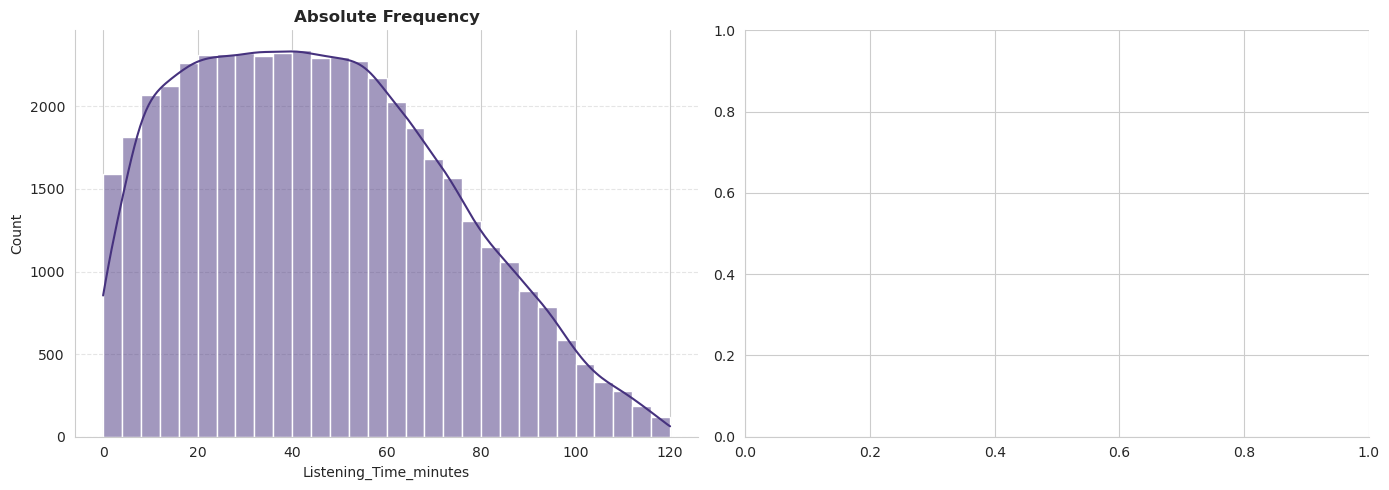

In [37]:
data_overview(original_data, 'Listening_Time_minutes')

## Data Overview

### General Information

- Number of rows and columns: 750000 x 12

- Column names:

['id',
 'Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'Listening_Time_minutes']

### Data Types & Missing Values

,Data Type,Missing Values
id,int64,0
Podcast_Name,object,0
Episode_Title,object,0
Episode_Length_minutes,float64,87093
Genre,object,0
Host_Popularity_percentage,float64,0
Publication_Day,object,0
Publication_Time,object,0
Guest_Popularity_percentage,float64,146030
Number_of_Ads,float64,1


### Classic head of Data

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,nan,True Crime,74.810000,Thursday,Night,nan,0.000000,Positive,31.419980
1,1,Joke Junction,Episode 26,119.800000,Comedy,66.950000,Saturday,Afternoon,75.950000,2.000000,Negative,88.012410
2,2,Study Sessions,Episode 16,73.900000,Education,69.970000,Tuesday,Evening,8.970000,0.000000,Negative,44.925310
3,3,Digital Digest,Episode 45,67.170000,Technology,57.220000,Monday,Morning,78.700000,2.000000,Positive,46.278240
4,4,Mind & Body,Episode 86,110.510000,Health,80.070000,Monday,Afternoon,58.680000,3.000000,Neutral,75.610310


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
id,750000.000000,374999.500000,216506.495284,0.000000,187499.750000,374999.500000,562499.250000,749999.000000
Episode_Length_minutes,662907.000000,64.504738,32.969603,0.000000,35.730000,63.840000,94.070000,325.240000
Host_Popularity_percentage,750000.000000,59.859901,22.873098,1.300000,39.410000,60.050000,79.530000,119.460000
Guest_Popularity_percentage,603970.000000,52.236449,28.451241,0.000000,28.380000,53.580000,76.600000,119.910000
Number_of_Ads,749999.000000,1.348855,1.151130,0.000000,0.000000,1.000000,2.000000,103.910000
Listening_Time_minutes,750000.000000,45.437406,27.138306,0.000000,23.178350,43.379460,64.811580,119.970000


## Target Variable: `Listening_Time_minutes`

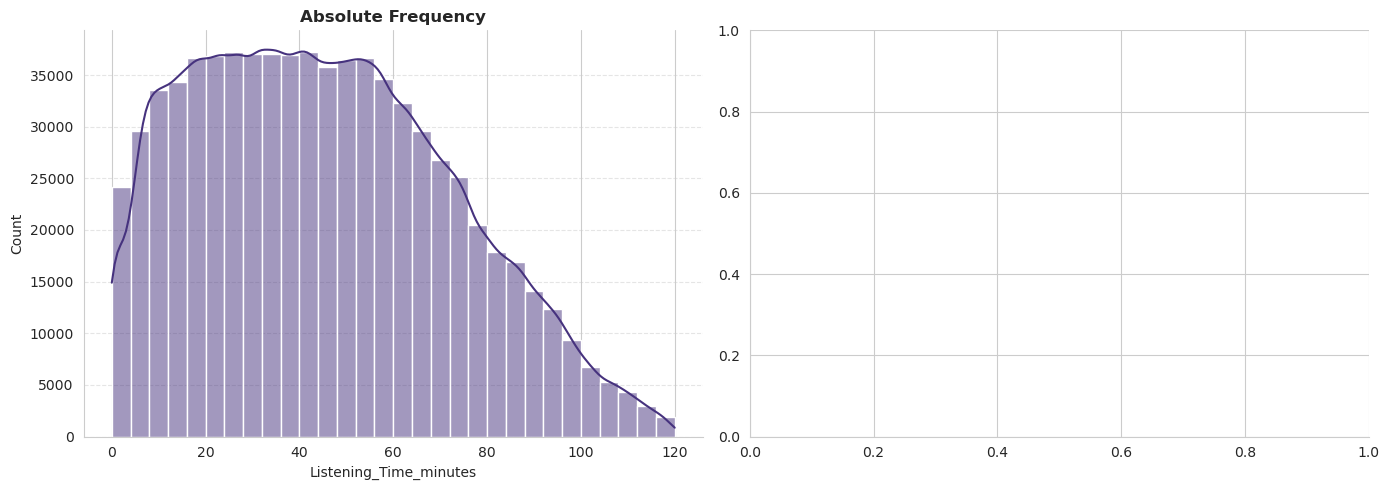

In [38]:
data_overview(train_original, 'Listening_Time_minutes')

In [39]:
data_overview(test_original, 'Listening_Time_minutes')

## Data Overview

### General Information

- Number of rows and columns: 250000 x 11

- Column names:

['id',
 'Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment']

### Data Types & Missing Values

,Data Type,Missing Values
id,int64,0
Podcast_Name,object,0
Episode_Title,object,0
Episode_Length_minutes,float64,28736
Genre,object,0
Host_Popularity_percentage,float64,0
Publication_Day,object,0
Publication_Time,object,0
Guest_Popularity_percentage,float64,48832
Number_of_Ads,float64,0


### Classic head of Data

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.960000,Education,38.110000,Saturday,Evening,53.330000,1.000000,Neutral
1,750001,Sound Waves,Episode 23,27.870000,Music,71.290000,Sunday,Morning,nan,0.000000,Neutral
2,750002,Joke Junction,Episode 11,69.100000,Comedy,67.890000,Friday,Evening,97.510000,0.000000,Positive
3,750003,Comedy Corner,Episode 73,115.390000,Comedy,23.400000,Sunday,Morning,51.750000,2.000000,Positive
4,750004,Life Lessons,Episode 50,72.320000,Lifestyle,58.100000,Wednesday,Morning,11.300000,2.000000,Neutral


### Statistical Summary (describe)

,count,mean,std,min,25%,50%,75%,max
id,250000.000000,874999.500000,72168.927986,750000.000000,812499.750000,874999.500000,937499.250000,999999.000000
Episode_Length_minutes,221264.000000,419.298741,166854.502468,2.470000,35.780000,63.970000,94.150000,78486264.000000
Host_Popularity_percentage,250000.000000,59.716491,22.880028,2.490000,39.250000,59.900000,79.390000,117.760000
Guest_Popularity_percentage,201168.000000,52.192796,28.445034,0.000000,28.320000,53.360000,76.560000,116.820000
Number_of_Ads,250000.000000,1.355852,4.274399,0.000000,0.000000,1.000000,2.000000,2063.000000


## Target Variable: `Listening_Time_minutes`

<Figure size 640x480 with 0 Axes>

# Quick PreProcessing at some features

Re order the orignal_data in the train order about the column:

In [40]:
train_original.drop('id', axis=1, inplace=True) #id is not needed for training
original_data = original_data[train_original.columns]
original_data.head(100)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,Joke Junction,Episode 22,70.26,Comedy,52.15,Saturday,Night,47.13,2,Neutral,41.755504
96,Crime Chronicles,Episode 84,60.58,True Crime,50.08,Wednesday,Afternoon,90.29,1,Neutral,NaN
97,Study Sessions,Episode 7,108.10,Education,38.74,Saturday,Morning,7.89,1,Neutral,108.100000
98,Educational Nuggets,Episode 69,42.09,Education,64.08,Tuesday,Morning,23.75,0,Neutral,42.090000


In [41]:
train_original.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Optional Point: Concat the data

In [ ]:
#Concat train and the original data set
train = train_original.copy()
test = test_original.copy()
test.drop('id', axis=1, inplace=True) #id is not needed for testing
train = pd.concat([train, original_data],ignore_index=True)

In [43]:
# just make sure to concat worked,check if the objecte type is the same
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.870580
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.462420
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.260000
749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.729390
749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.944390
750000,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3.0,Positive,55.158695
750001,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1.0,Neutral,7.686559
750002,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3.0,Neutral,110.064645
750003,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0.0,Positive,12.000380
750004,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3.0,Positive,NaN


# Feature Analyse

## Numeric Feature Attributes

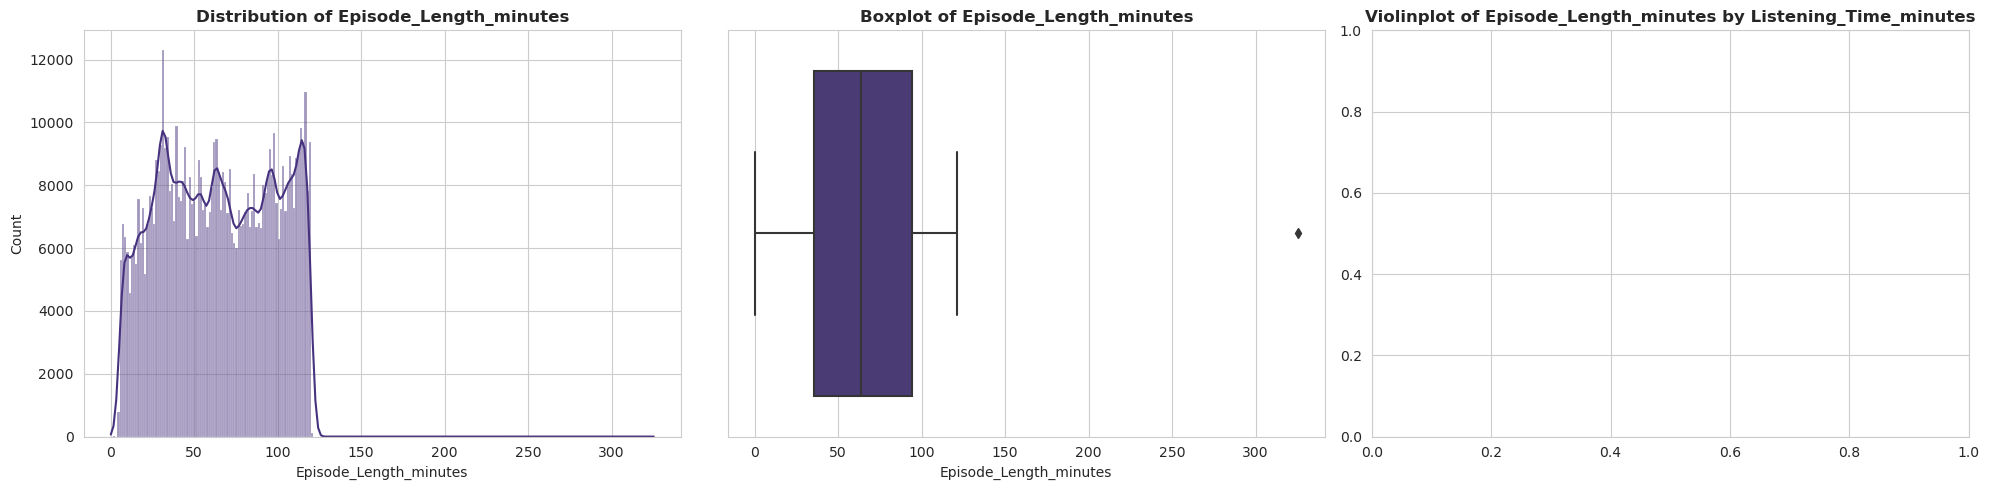

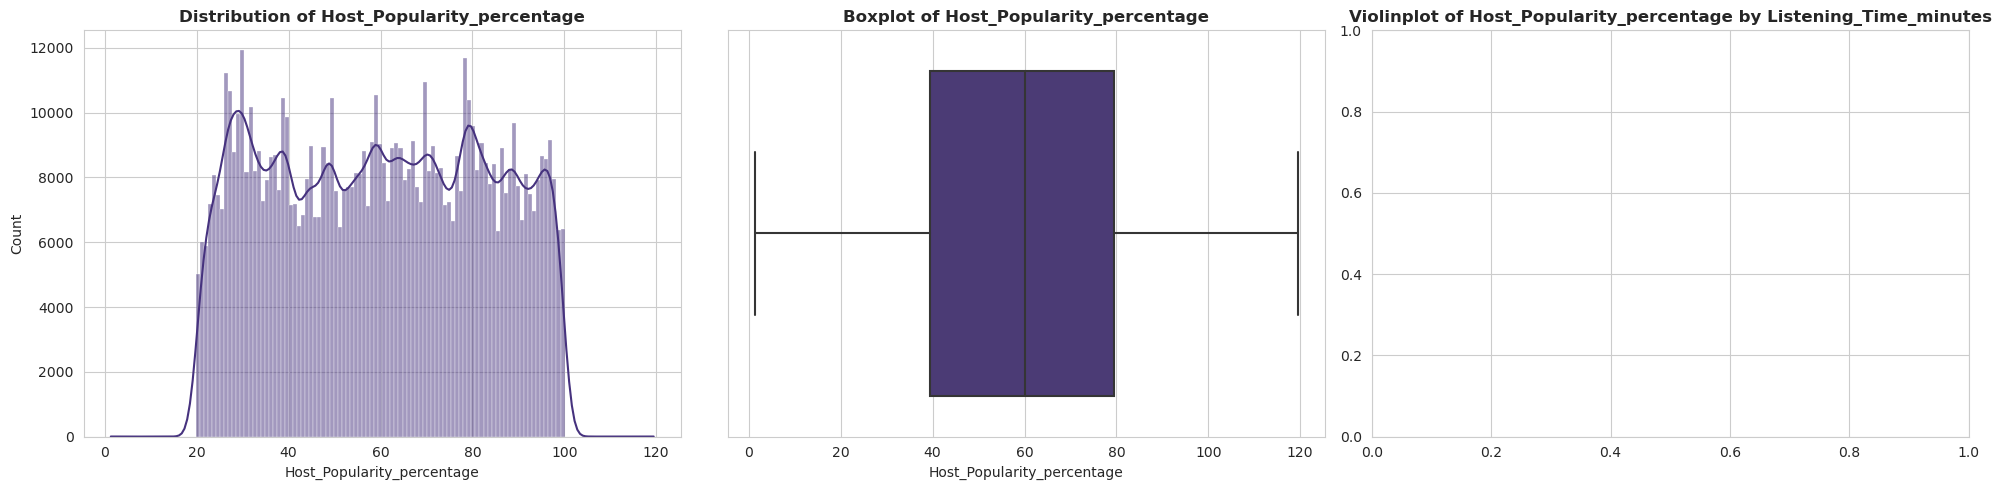

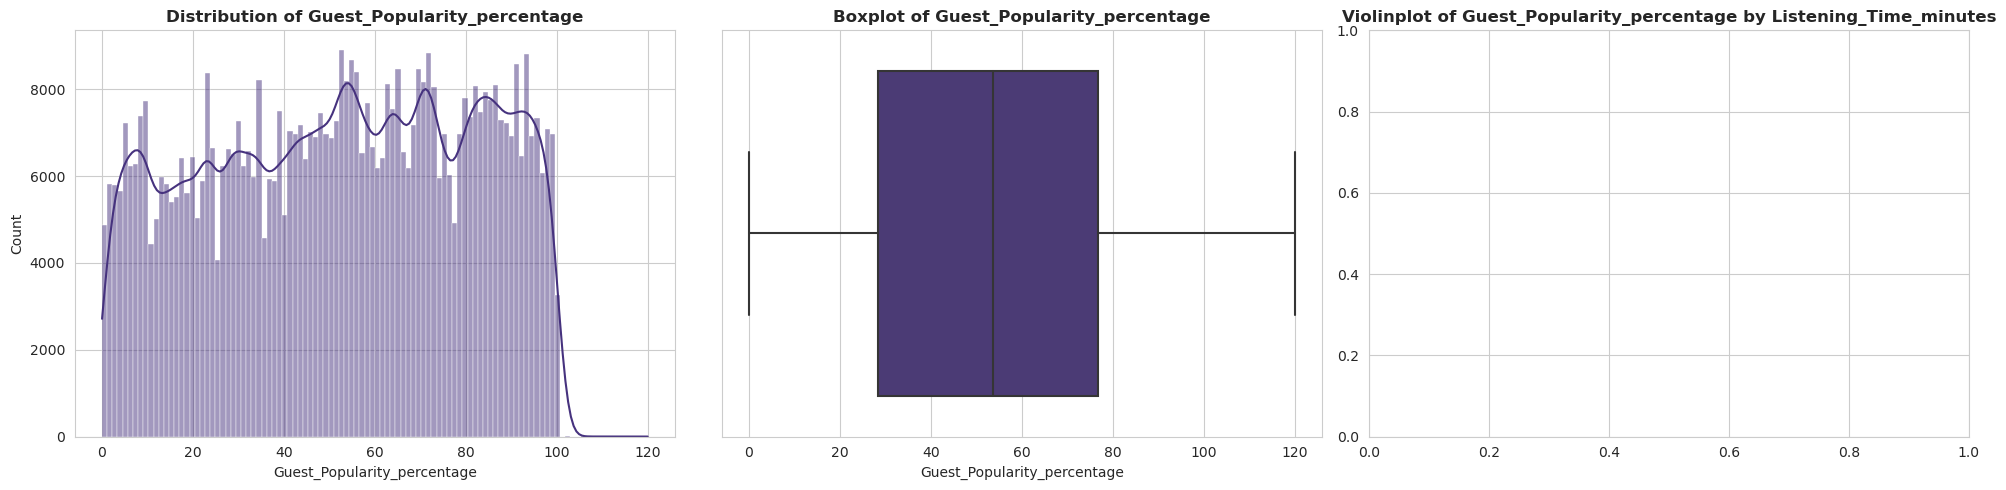

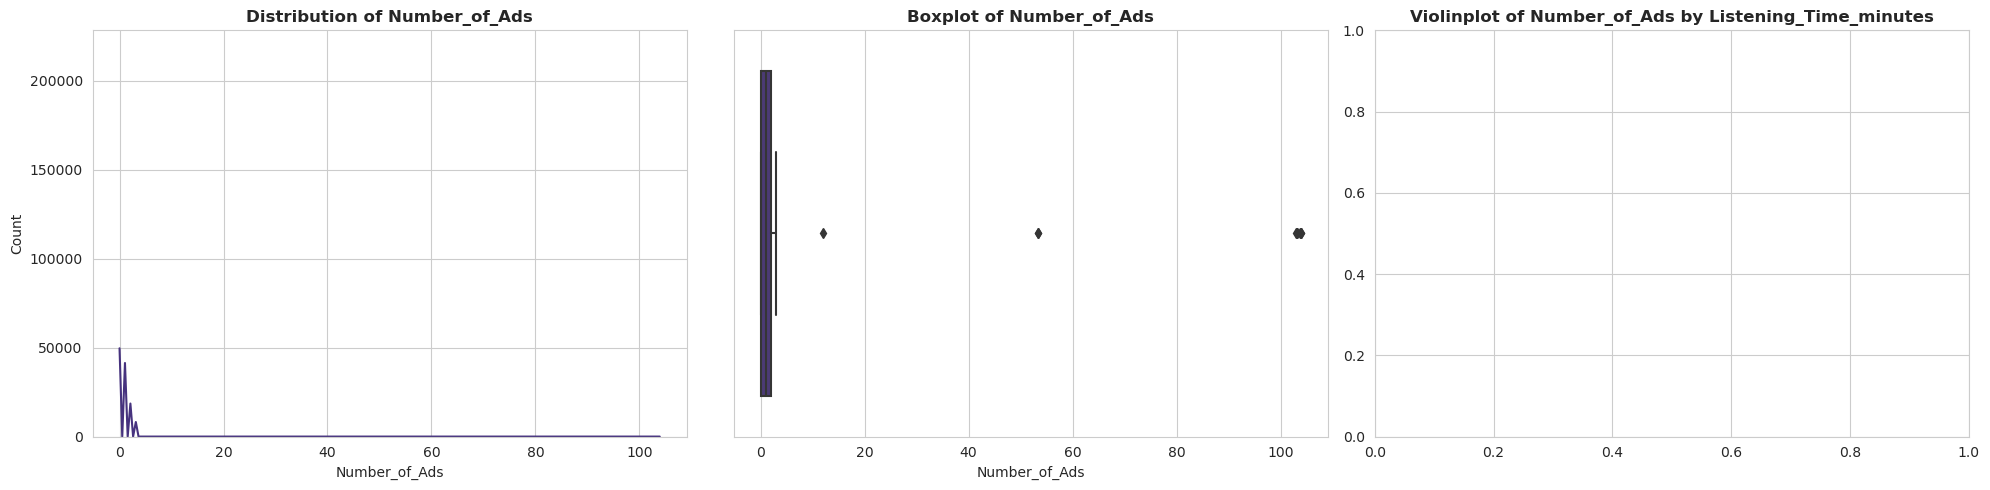

## Categorical Feature Attributes

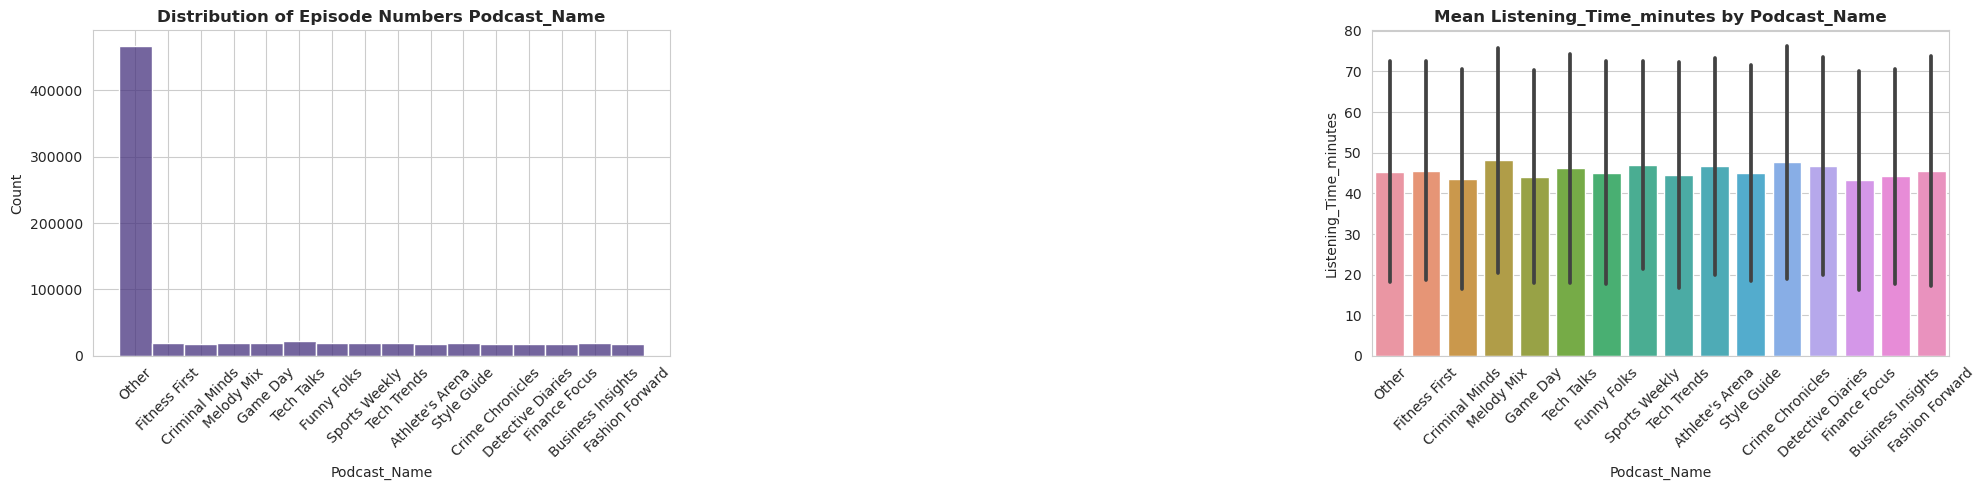

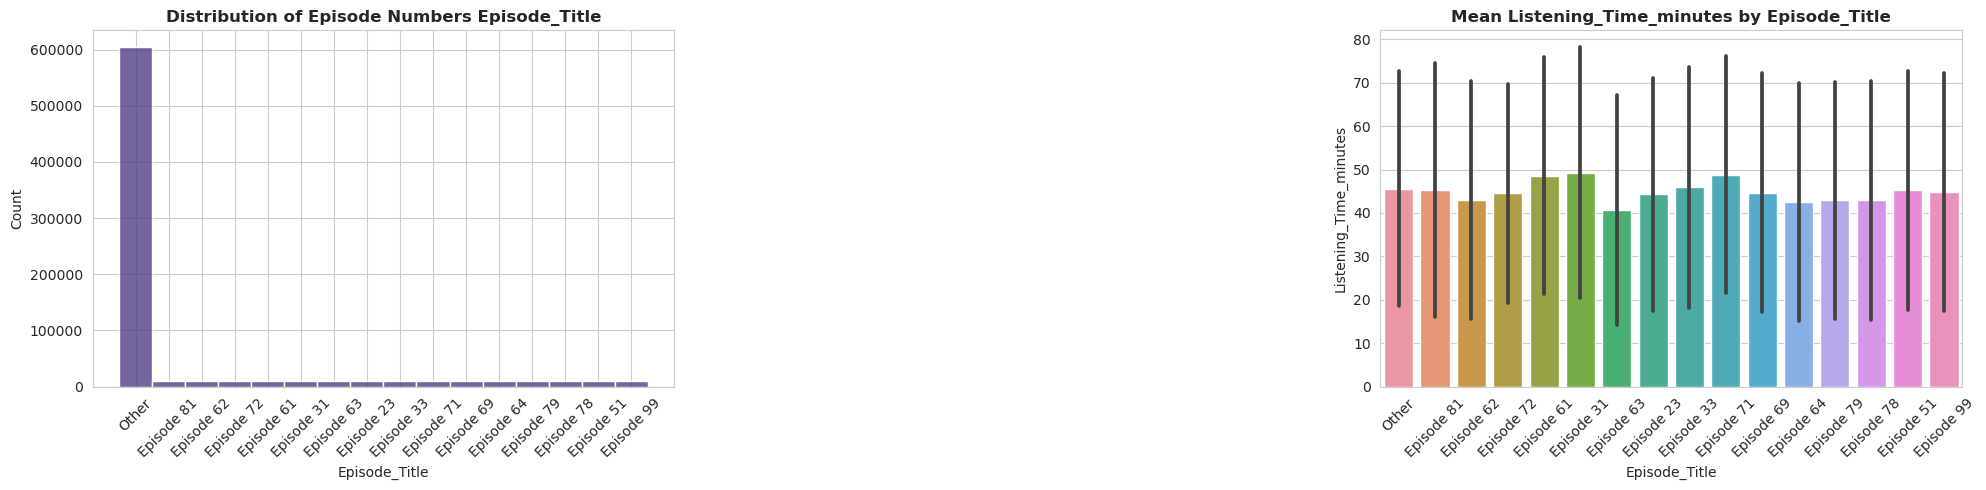

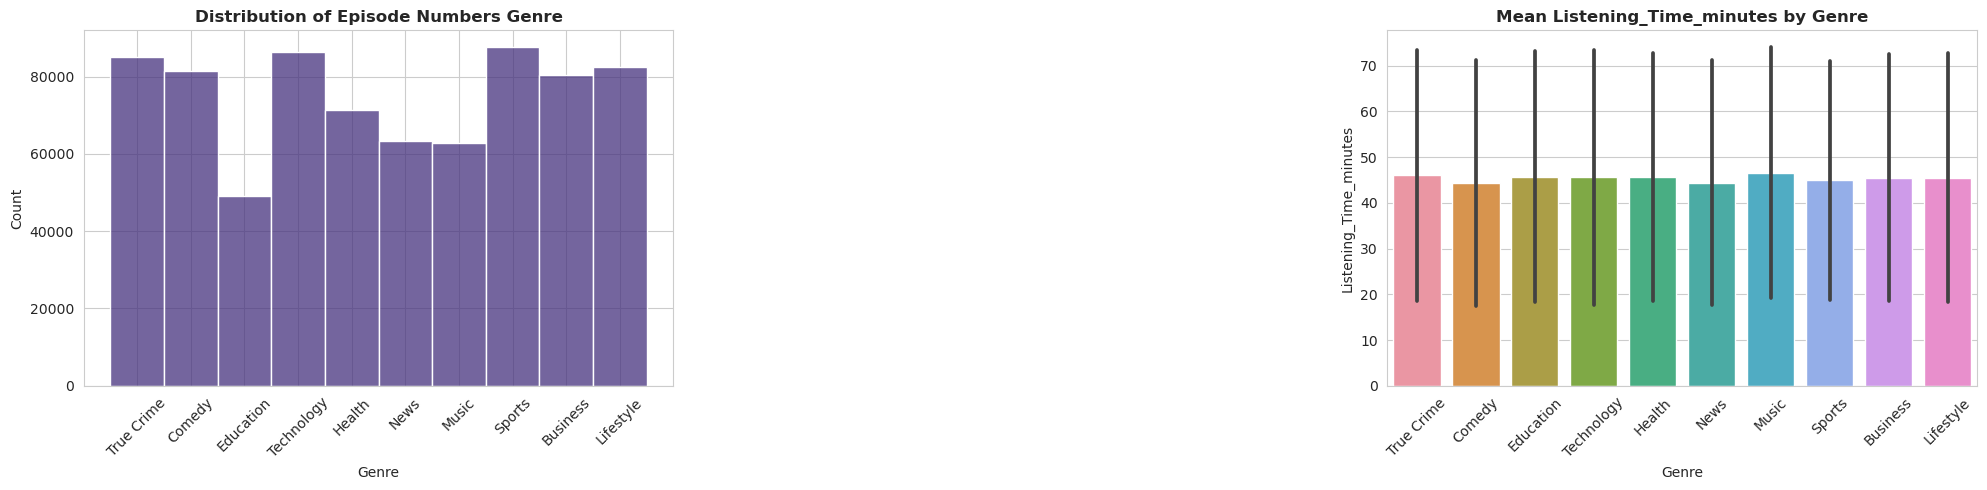

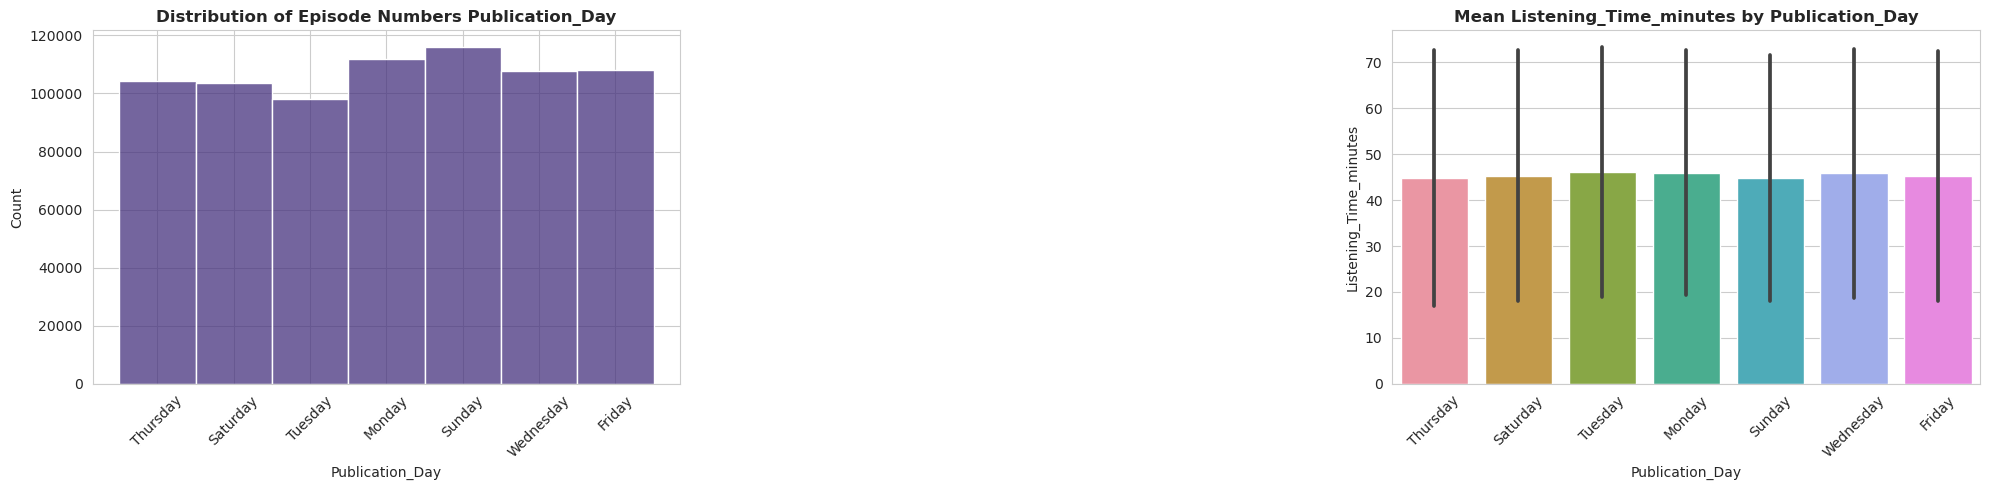

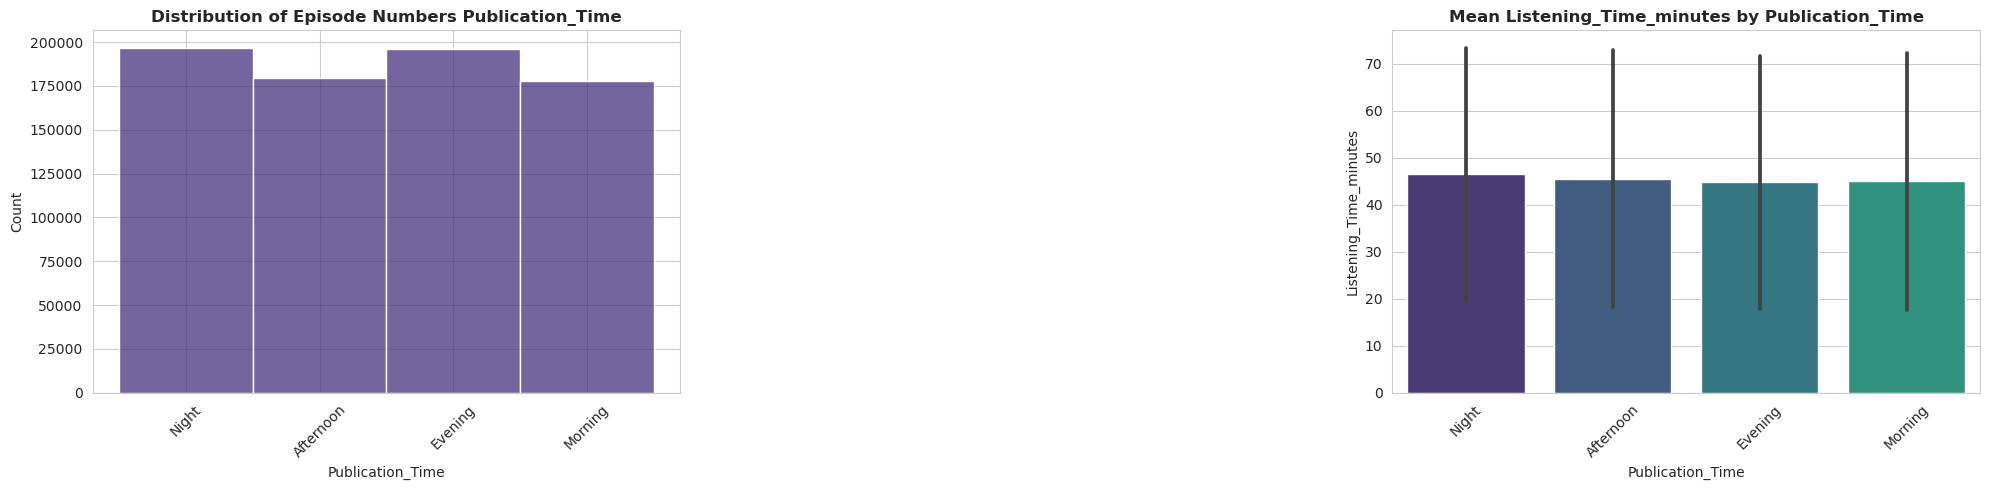

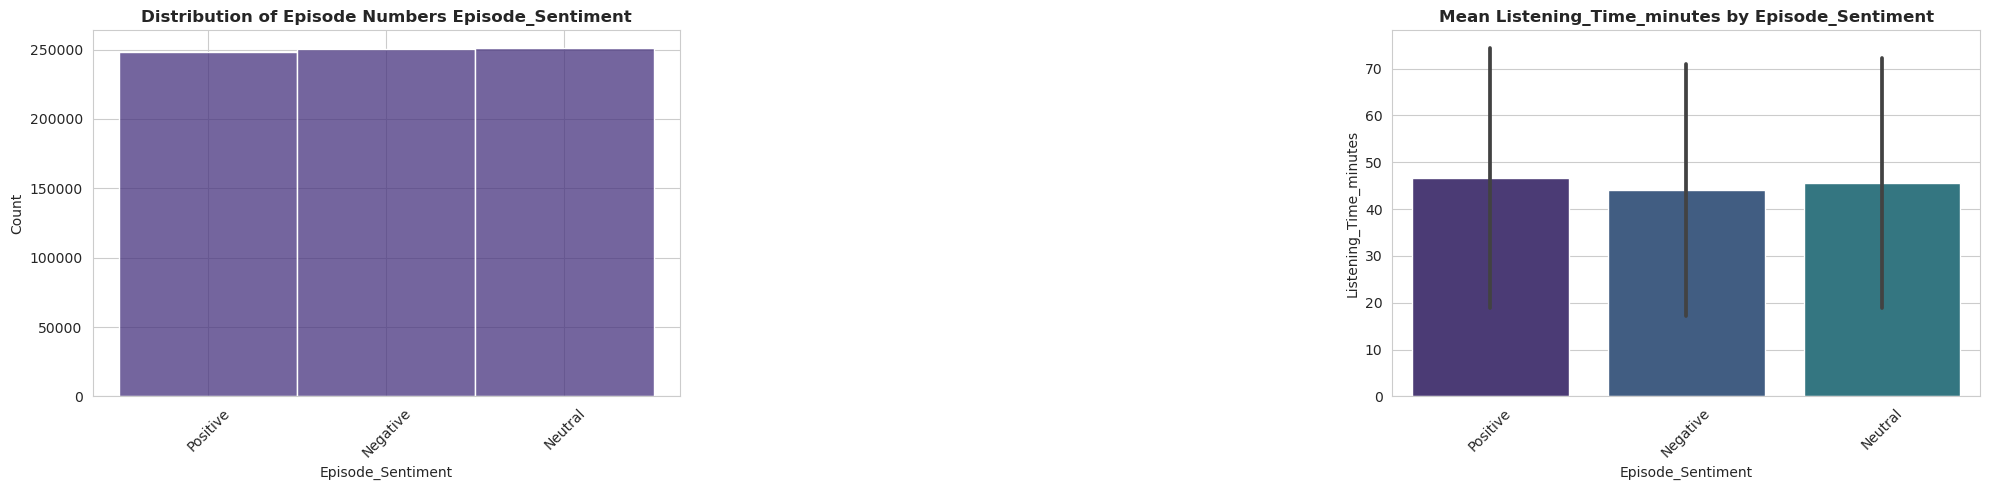

In [44]:
def visualize_feature_attributes(df, target=None):
    """ Visualizes numeric and categorical features """

    # Get Numeric & Categorical Features
    numeric_features, categorical_features =get_categorical_numerical_features(df)

    # Numeric Features
    if numeric_features:
        display(Markdown("## Numeric Feature Attributes"))
        for col in numeric_features:
            if col != target:
                plot_numeric_feature(df, col, target)
    else:
        print("No numeric features found.")

    # Categorical Features
    if categorical_features:
        display(Markdown("## Categorical Feature Attributes"))
        for col in categorical_features:
            if col != target:
                if df[col].nunique() > 10:
                    df[col] = reduce_categories(df[col], top_n=15)
                plot_categorical_feature(df, col, target)
    else:
        print("No categorical features found.")


def plot_numeric_feature(df, col, target):
    """ Plots Histogram, Boxplot, and Violinplot for a numeric feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(df[col], ax=axes[0], kde=True)
    axes[0].set_title(f"Distribution of {col}", fontweight="bold")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}", fontweight="bold")

    # if target and target in df.columns and df[target].nunique() == 2:
    #     sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=True)
    # elif target and target in df.columns:
    #     sns.violinplot(x=df[target], y=df[col], ax=axes[2], split=False)
    # else:
    #     sns.violinplot(y=df[col], ax=axes[2])

    axes[2].set_title(f"Violinplot of {col} by {target}", fontweight="bold")

    plt.tight_layout()
    plt.show()


def plot_categorical_feature(df, col, target):
    """ Plots Countplot, Hue-Countplot, and Barplot (if target is numeric) for a categorical feature """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # sns.countplot(x=df[col], ax=axes[0])
    sns.histplot(x=df[col], bins=30, ax=axes[0])
    # axes[0].set_title(f"Countplot of {col}", fontweight="bold")
    axes[0].set_title(f"Distribution of Episode Numbers {col}", fontweight="bold")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot 2: Countplot with hue (only if hue has few unique values)
    if target in df.columns and df[target].nunique() <= 10:
        sns.countplot(x=df[col], hue=df[target], ax=axes[1])
        axes[1].set_title(f"Countplot of {col} by {target}", fontweight="bold")
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].remove()


    # Plot 3: Barplot of mean target per category
    if target in df.columns and df[target].dtype in [np.float64, np.int64]:
        sns.barplot(x=df[col], y=df[target], ax=axes[2], estimator=np.mean, errorbar='sd')
        axes[2].set_title(f"Mean {target} by {col}", fontweight="bold")
        axes[2].tick_params(axis='x', rotation=45)
    else:
        axes[2].remove()

    plt.tight_layout()
    plt.show()
    

# def reduce_categories(df, col, top_n):
#     """ Shows only the categories with highes numbers, seldoms are shown with "others" """
#     top_categories = df[col].value_counts().nlargest(top_n).index
#     df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
#     return df

def reduce_categories(col_series, top_n):
    top_categories = col_series.value_counts().nlargest(top_n).index
    return col_series.apply(lambda x: x if x in top_categories else 'Other')


def get_categorical_numerical_features(df):
    # Get Numeric & Categorical Features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_features, categorical_features

visualize_feature_attributes(train_original, target="Listening_Time_minutes")

# Correlation Matrix (Numerical values)

<Axes: >

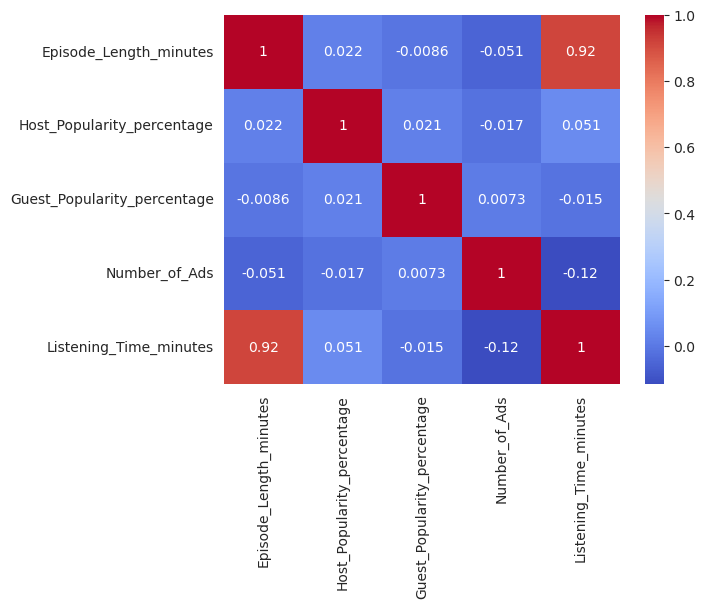

In [45]:
# # Get Numeric & Categorical Features
numeric_features, categorical_features = get_categorical_numerical_features(train)
sns.heatmap(train[numeric_features].corr(), annot=True, cmap='coolwarm')

# Analyse categorical features

In [46]:
# for col in categorical_features:
#     plot_heatmap(train, col, 'Listening_Time_minutes')

# Correlation Matrix Categorical Features

In [47]:
# for col in train[categorical_features]:
#     print(col)
#     print(cramers_v(train[col], train["Listening_Time_minutes"]))

# Merge categorical features

In [48]:
# merge_features = ['Working Professional or Student', 'Degree', 'Have you ever had suicidal thoughts ?']
# for col in merge_features:
#     train = merge_rare_categories(train, col, 15)
#     test = merge_rare_categories(test, col, 15)
#     plot_heatmap(train, col, 'Depression')
#     #plot_heatmap(test, col, 'Depression')

# Analyze
## Numerical Features



## Categorical Features


# Save CSV Files as Kaggle Datasets

In [49]:
# if KAGGLE_ENV:
#     train.to_csv('/kaggle/input/s5-e4-train-concat/s5-e4-train-concat.csv', index=False)
# else:
#     train.to_csv('../kaggle/input/' + '/s5-e4-train-concat/s5-e4-train-concat.csv', index=False)

In [50]:
# # save test data set
# if KAGGLE_ENV:
#     test.to_csv('/kaggle/input/s5-e4-test-concat/s5-e4-test-concat.csv', index=False)
# else:
#     test.to_csv( '../kaggle/input/' + '/s5-e4-test-concat/s5-e4-test-concat.csv', index=False)

In [51]:
# train.head()

In [52]:
# test.head()